In [1]:
import numpy as np
import pandas as pd
from numba import njit

import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

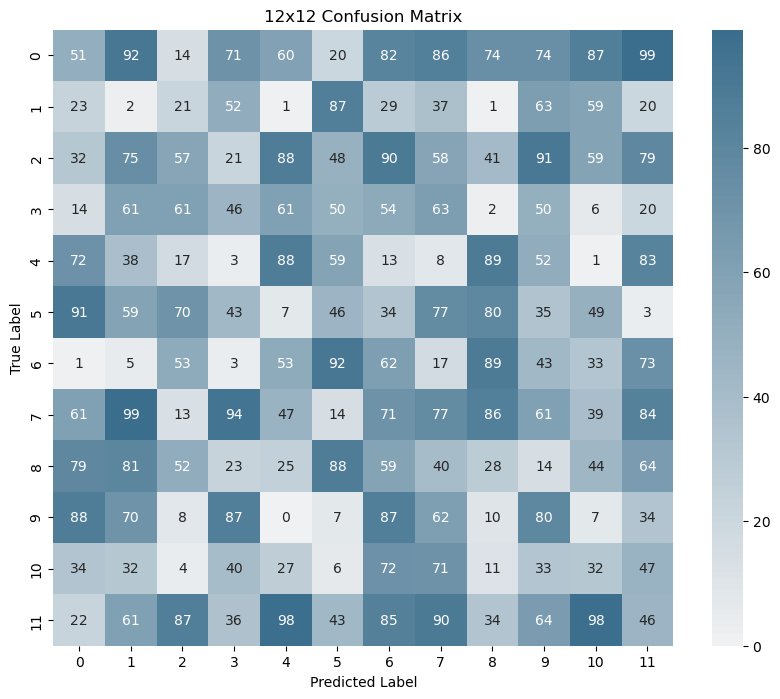

In [20]:
# Generate a random 12x12 confusion matrix with integer values
np.random.seed(42)  # For reproducibility
conf_matrix = np.random.randint(0, 100, size=(12, 12))

# Define class labels
class_dict = {
    'Accessible suburbia': 0,
    'Connected residential neighbourhoods': 1,
    'Countryside agriculture': 2,
    'Dense residential neighbourhoods': 3,
    'Dense urban neighbourhoods': 4,
    'Disconnected suburbia': 5,
    'Gridded residential quarters': 6,
    'Open sprawl': 7,
    'Urban buffer': 8,
    'Urbanity': 9,
    'Warehouse/Park land': 10,
    'Wild countryside': 11
}

# Reverse lookup for labels
class_labels = {v: k for k, v in class_dict.items()}

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.light_palette(ugg.HEX[1], n_colors=100), xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("12x12 Confusion Matrix")
plt.show()

In [21]:
@njit
def nscore(a):
    ds = []
    r = range(len(a))
    for i in r:
        for j in r:
            if a[i, j] != 0:
                ds.append(abs(i-j))
    return np.array(ds).mean()

@njit
def wnscore(a):
    ds = []
    r = range(len(a))
    total = a.sum()
    for i in r:
        for j in r:
            aij = a[i, j]
            if aij != 0:
                ds.append(abs(i-j) * aij / total)
    return np.array(ds).mean()



#Bit hacky but fast(er) sorting algorithm that doesn't use all permutations (which takes more than 1h for a 12x12 grid).
def simulated_annealing(a, w=True, max_iters=500000, temp=1.0, cooling_rate=0.995):
    """
    Optimizes the row/column order using simulated annealing.
    
    Args:
        a: The 2D numpy array.
        w: Whether to use weighted nscore.
        max_iters: Maximum number of iterations.
        temp: Initial temperature for annealing.
        cooling_rate: Decay rate for temperature.

    Returns:
        The best found permutation.
    """
    if w:
        scorer = wnscore
    else:
        scorer = nscore

    la = len(a)
    
    # Initial permutation (sorted by row sums as a heuristic)
    current_perm = np.argsort(a.sum(axis=1))
    best_perm = current_perm.copy()
    best_score = scorer(a[current_perm, :][:, current_perm])

    for _ in range(max_iters):
        temp *= cooling_rate  # Reduce temperature

        # Swap two random indices
        new_perm = current_perm.copy()
        i, j = np.random.choice(la, 2, replace=False)
        new_perm[i], new_perm[j] = new_perm[j], new_perm[i]

        # Compute new score
        new_score = scorer(a[new_perm, :][:, new_perm])
        
        # Accept new permutation if it's better or with a probability
        if new_score < best_score or np.exp((best_score - new_score) / temp) > np.random.rand():
            current_perm = new_perm
            best_score = new_score
            best_perm = new_perm

        # Stop early if temperature is too low
        if temp < 1e-6:
            break

    return best_perm

In [22]:
#cols = list(class_labels.values())  # Get class labels as list
cols = list(range(0,12))
tab = pd.DataFrame(conf_matrix)  # Copy the transition matrix

# ensure column names match correctly
#cols = [i.strip() for i in cols]  # Remove any unwanted spaces
stab = tab.loc[cols, cols]  # Reorder based on labels

# remove the diagonal
stab_no_diag = stab.copy()
np.fill_diagonal(stab_no_diag.values, 0)  # Set diagonal to zero

# Sorting
order = simulated_annealing(stab_no_diag.values, w=False)  # Unweighted score sorting
weighted_order = simulated_annealing(stab_no_diag.values, w=True)  # Weighted score sorting

stab_sorted = stab.iloc[order, order]  # Reorder rows and columns

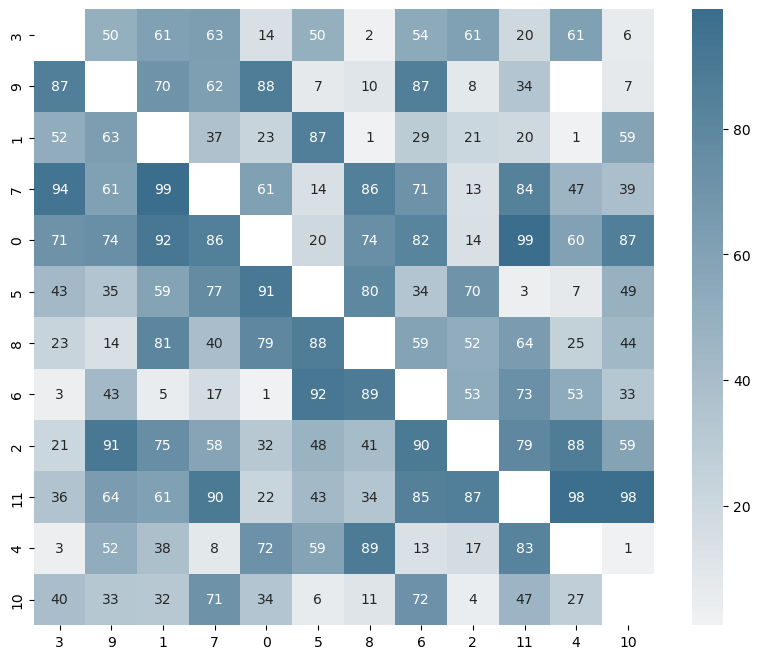

In [24]:
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap((stab_no_diag.iloc[weighted_order, weighted_order]).replace(0, np.nan).astype('float'), 
            cmap=sns.light_palette(ugg.HEX[1], n_colors=100),
            annot=True)

# Show plot
plt.show()